## Imports

In [ ]:
%matplotlib inline

In [1]:
# Importing Libraries

# Custom Functions
from mushroom_utils import *

# Data Exploration
import pandas as pd
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math

# Pipelining
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_regression, RFECV, SelectFromModel

# Modeling
from sklearn.tree import plot_tree, DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Scoring
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay

In [2]:
# Reading Training Data
mushrooms_df = pd.read_csv('train.csv')
mushrooms_df = mushrooms_df.drop_duplicates()

# Reading Test Data
test_df = pd.read_csv('test.csv')

## Data Exploration
Lessons: 
* Data set is balanced, around 51.4% safe 48.6% poisonous --> **ROC viable**
* Dataset has 6500 entries and 6 features (excl ID)
* Dataset has no nulls --> **no imputation needed**
* Dataset has no numerical columns --> **no numerical pipeline needed**
* Only population feature could be seen as ordinal, but given the nature of species identification all should be coded with onehot --> **no ordinal encoder needed**

In [3]:
mushrooms_df.shape # 6500 entries
mushrooms_df.info() # No nulls

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6499 entries, 0 to 6498
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   cap.shape               6499 non-null   object
 1   cap.color               6499 non-null   object
 2   bruises                 6499 non-null   bool  
 3   stalk.color.above.ring  6499 non-null   object
 4   stalk.color.below.ring  6499 non-null   object
 5   population              6499 non-null   object
 6   Id                      6499 non-null   int64 
 7   poisonous               6499 non-null   int64 
dtypes: bool(1), int64(2), object(5)
memory usage: 412.5+ KB


In [4]:
mushroom_profile = ProfileReport(mushrooms_df, minimal=True)
mushroom_profile.to_file('mushroom_report.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## Data Cleaning
* No cleaning necessary

## Data Splitting

In [3]:
# Separating Predictor Features (X) and Target Feature (y)
X = mushrooms_df
y = X.pop('poisonous')

In [4]:
# Seperating Test Data From Training Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# Defining Data Types
drop_features = ['Id']
predictor_features = list(set(X.columns)-set(drop_features))

## Preprocessing

In [6]:
# Creating Preprocessor
preprocessor = ColumnTransformer(transformers=[
    ("columns_to_drop", 'drop', drop_features),
    ("onehot", OneHotEncoder(drop='first', sparse_output=False, handle_unknown="ignore"), predictor_features)])

# Modeling, Scoring, and Submitting

## Modelling

### Random Forest Classifier

In [13]:
# Creating Pipeline with Random Forest Classifier
rf_pipeline = make_pipeline(preprocessor,
                            RandomForestClassifier(bootstrap=True,
                                                   oob_score=True,
                                                   criterion='gini',
                                                   max_features=None,
                                                   max_depth=5,
                                                   n_estimators=35,
                                                   min_samples_leaf=3))

# Fitting Pipeline to Training Data
rf_pipeline.fit(X_train, y_train)

# Defining Parameter Grid
rf_param_grid = {
    #'randomforestclassifier__n_estimators': range(35, 110, 15), #6
    #'randomforestclassifier__max_depth': range(4, 7), # 4
    #'randomforestclassifier__min_samples_leaf': range(3, 8), # 6
    #'randomforestclassifier__max_features':['balanced','balanced_subsample', None]
}

# Performing Search to Optimize Hyperparameters
rf_search = GridSearchCV(rf_pipeline,
                         rf_param_grid,
                         scoring='recall',
                         cv=7)

# Fitting Model to Training Data
rf_search.fit(X_train, y_train)

c:\Users\rockw\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


GridSearchCV(cv=7,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('columns_to_drop',
                                                                         'drop',
                                                                         ['Id']),
                                                                        ('onehot',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['bruises',
                                                                          'cap.shape',
                                                                          'population',
                                                                          'cap.color',
                                                                          'stalk.color.above.ring',
                                                                          'stalk.color.below.ring'])])),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(max_depth=5,
                                                               max_features=None,
                                                               min_samples_leaf=3,
                                                               n_estimators=35,
                                                               oob_score=True))]),
             param_grid={}, scoring='recall')

In [9]:
# Checking Best Parameters
rf_search.best_params_
# max depth = 5  --  5
# min samp = 10  --  6
# n estimators = 50  --  80

{'randomforestclassifier__min_samples_leaf': 3,
 'randomforestclassifier__n_estimators': 35}

#### Random Forest Scoring

In [14]:
# Identifying Highest Threshold Without False Negatives
rf_thresh_df, rf_safest_thresh = get_safest_thresh(X_train, y_train, rf_search)
print(rf_safest_thresh)

0.08516192000565781


In [15]:
# Displaying Scores
train_pred_scores, test_pred_scores, train_rec_scores, test_rec_scores = full_scoring(X_train, y_train, X_test, y_test, rf_search, 'Random Forest')
display(train_pred_scores)
display(test_pred_scores)
display(train_rec_scores)
display(test_rec_scores)

,Accuracy,Precision,Recall,AUC,F1,Oportunity Cost,Killed
Random Forest Train Prediction,0.943451,0.904675,0.986853,0.984489,0.943979,261,33


,Accuracy,Precision,Recall,AUC,F1,Oportunity Cost,Killed
Random Forest Test Prediction,0.936923,0.901849,0.979907,0.982634,0.939259,69,13


,Accuracy,Precision,Recall,AUC,F1,Oportunity Cost,Killed
Random Forest Train Recommendation,0.895557,0.822142,1.0,0.984489,0.902391,543,0


,Accuracy,Precision,Recall,AUC,F1,Oportunity Cost,Killed
Random Forest Test Recommendation,0.89,0.818987,1.0,0.982634,0.900487,143,0


### Gradient Boost Classifier

In [8]:
# Creating Pipeline with Random Forest Classifier
gb_pipeline = make_pipeline(preprocessor,
                            GradientBoostingClassifier(max_features=None,
                                                       max_depth=5,
                                                       n_estimators=50,
                                                       min_samples_leaf=7))

# Fitting Pipeline to Training Data
gb_pipeline.fit(X_train, y_train)

# Defining Parameter Grid
gb_param_grid = {
    #'gradientboostingclassifier__n_estimators': range(35, 110, 15), #6
    #'gradientboostingclassifier__max_depth': range(4, 7), # 4
    #'gradientboostingclassifier__min_samples_leaf': range(3, 8), # 6
    #'gradientboostingclassifier__max_features':['balanced','balanced_subsample', None]
}

# Performing Search to Optimize Hyperparameters
gb_search = GridSearchCV(gb_pipeline,
                         gb_param_grid,
                         scoring='recall',
                         cv=7)

# Fitting Model to Training Data
gb_search.fit(X_train, y_train)

c:\Users\rockw\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\rockw\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\rockw\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\rockw\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\rockw\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Foun

GridSearchCV(cv=7,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('columns_to_drop',
                                                                         'drop',
                                                                         ['Id']),
                                                                        ('onehot',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['bruises',
                                                                          'cap.shape',
                                                                          'population',
                                                                          'cap.color',
                                                                          'stalk.color.above.ring',
                                                                          'stalk.color.below.ring'])])),
                                       ('gradientboostingclassifier',
                                        GradientBoostingClassifier(max_depth=5))]),
             param_grid={'gradientboostingclassifier__min_samples_leaf': range(3, 8),
                         'gradientboostingclassifier__n_estimators': range(35, 110, 15)},
             scoring='recall')

In [9]:
# Checking Best Parameters
gb_search.best_params_
# max depth = 5 
# min samp = 7
# n estimators = 50

{'gradientboostingclassifier__min_samples_leaf': 7,
 'gradientboostingclassifier__n_estimators': 50}

#### Gradient Boosting Scoring

In [10]:
# Identifying Highest Threshold Without False Negatives
gb_thresh_df, gb_safest_thresh = get_safest_thresh(X_train, y_train, gb_search)
print(gb_safest_thresh)

0.1286245884914091


In [11]:
# Displaying Scores
train_pred_scores, test_pred_scores, train_rec_scores, test_rec_scores = full_scoring(X_train, y_train, X_test, y_test, gb_search, 'Gradient Boosting')
display(train_pred_scores)
display(test_pred_scores)
display(train_rec_scores)
display(test_rec_scores)

,Accuracy,Precision,Recall,AUC,F1,Oportunity Cost,Killed
Gradient Boosting Train Prediction,0.957684,0.932402,0.983665,0.994926,0.957348,179,41


,Accuracy,Precision,Recall,AUC,F1,Oportunity Cost,Killed
Gradient Boosting Test Prediction,0.954615,0.933628,0.978362,0.993857,0.955472,45,14


,Accuracy,Precision,Recall,AUC,F1,Oportunity Cost,Killed
Gradient Boosting Train Recommendation,0.929602,0.87274,1.0,0.994926,0.932046,366,0


,Accuracy,Precision,Recall,AUC,F1,Oportunity Cost,Killed
Gradient Boosting Test Recommendation,0.927692,0.873144,1.0,0.993857,0.932277,94,0


## Plotting Performances

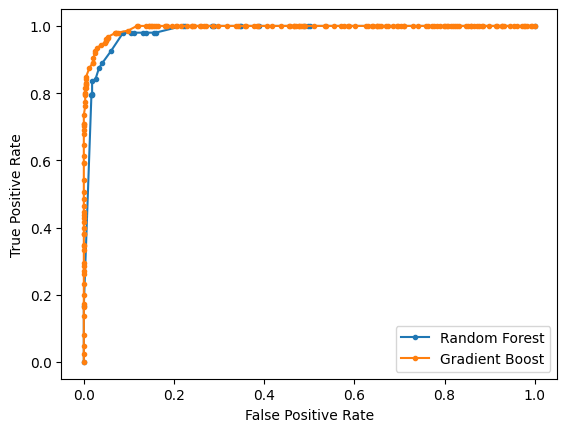

In [16]:
# Plotting ROC Curve

# Plotting Random Forest
rf_probs = rf_search.predict_proba(X_test)[:,1]
rf_fpr, rf_tpr, thresh = roc_curve(y_test, rf_probs)
plt.plot(rf_fpr, rf_tpr, marker = '.', label = 'Random Forest')

# Plotting Gradient Boost
gb_probs = gb_search.predict_proba(X_test)[:,1]
gb_fpr, gb_tpr, thresh = roc_curve(y_test, gb_probs)
plt.plot(gb_fpr, gb_tpr, marker = '.', label = 'Gradient Boost')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

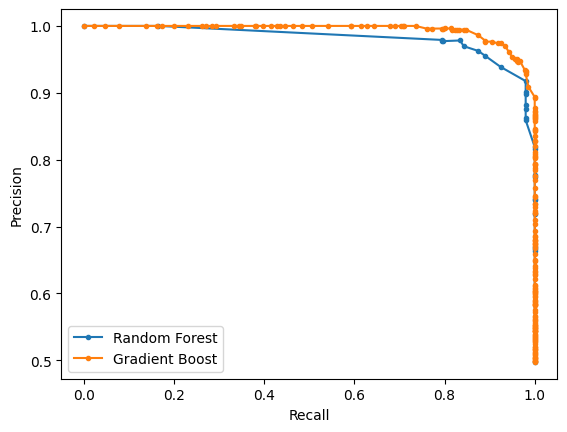

In [17]:
# Plotting Precision-Recall Curve

# Plotting Random Forest
rf_precision, rf_recall, _ = precision_recall_curve(y_test, rf_probs)
plt.plot(rf_recall, rf_precision, marker='.', label = 'Random Forest')

# Plotting Gradient Boost
gb_precision, gb_recall, _ = precision_recall_curve(y_test, gb_probs)
plt.plot(gb_recall, gb_precision, marker='.', label = 'Gradient Boost')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

# Submitting

In [18]:
# Create CSV with Test Answers
prep_for_sub(rf_search, rf_safest_thresh, test_df, 'random_forest')
prep_for_sub(gb_search, gb_safest_thresh, test_df, 'gradient_boost')

# TO FIX

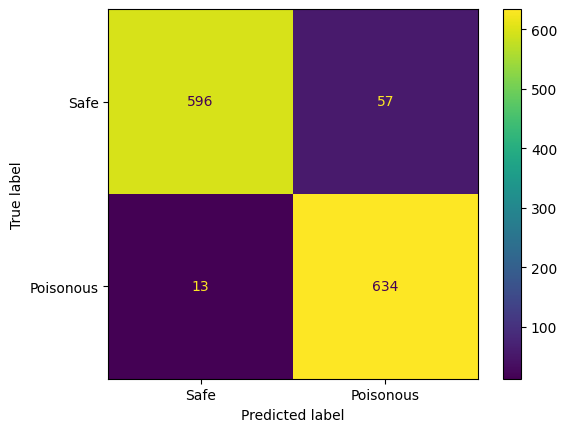

In [60]:
# Decision Tree Confusion Matrix
ConfusionMatrixDisplay.from_estimator(rf_search, 
                                      X_test, 
                                      y_test, 
                                      display_labels=['Safe', 'Poisonous'])